---
title: DART-CAM6 reanalysis diagnostic plots
author: Harsha R. Hampapura
date: 2026-02-11
---

- This notebook is adapted from the DART-CAM6 example notebook on AWS
- https://ncar-dart-cam6.s3-us-west-2.amazonaws.com/examples/plot-ensemble-values.html

### Input Data Access

- This notebook illustrates how to make diagnostic plots hosted from the DART reanalysis stored on NCAR's GDEX
- https://gdex.ucar.edu/datasets/d345001/#
- This data is open access and can be accessed via 2 protocols
- 1) HTTPS (if you have access to NCAR's HPC)
- 2) OSDF using an intake-ESM catalog.

In [1]:
# Imports
import intake
import numpy as np
import pandas as pd
import xarray as xr
import seaborn as sns
import re
import matplotlib.pyplot as plt
import dask 
from dask_jobqueue import PBSCluster
from dask.distributed import Client
from dask.distributed import performance_report
import os

In [2]:
init_year0  = '1991'
init_year1  = '2020'
final_year0 = '2071'
final_year1 = '2100'

In [3]:
# Set up your sratch folder path
username       = os.environ["USER"]
glade_scratch  = "/glade/derecho/scratch/" + username
print(glade_scratch)
#
catalog_url = 'https://osdata.gdex.ucar.edu/d345001/catalogs/d345001-osdf.json'
# catalog_url = 'https://osdf-data.gdex.ucar.edu/ncar-gdex/d345001/catalogs/d345001-https-zarr.json' #NCAR's Object store
print(catalog_url)

/glade/derecho/scratch/harshah
https://osdata.gdex.ucar.edu/d345001/catalogs/d345001-osdf.json


## Create a PBS cluster

In [4]:
# Create a PBS cluster object
cluster = PBSCluster(
    job_name = 'dask-wk24-hpc',
    cores = 1,
    memory = '8GiB',
    processes = 1,
    local_directory = glade_scratch+'/dask/spill',
    log_directory = glade_scratch + '/dask/logs/',
    resource_spec = 'select=1:ncpus=1:mem=8GB',
    queue = 'casper',
    walltime = '5:00:00',
    #interface = 'ib0'
    interface = 'ext'
)

/glade/u/home/harshah/.conda/envs/osdf/lib/python3.11/site-packages/distributed/node.py:188: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 40691 instead
  warnings.warn(


In [5]:
# Create the client to load the Dashboard
client = Client(cluster)
n_workers = 8
cluster.scale(n_workers)
client.wait_for_workers(n_workers = n_workers)
cluster

PBSCluster(49115842, 'tcp://128.117.208.68:44389', workers=8, threads=8, memory=64.00 GiB)

## Load DART Reanalysis data from GDEX using an intake catalog

In [6]:
col = intake.open_esm_datastore(catalog_url)
col

,unique
variable,11
long_name,11
units,6
standard_name,10
vertical_levels,2
component,2
spatial_domain,1
start_time,2
end_time,2
frequency,2


### Load data into xarray using catalog

In [7]:
data_var = 'PS'

col_subset = col.search(variable=data_var)
col_subset

,unique
variable,1
long_name,1
units,1
standard_name,1
vertical_levels,1
component,1
spatial_domain,1
start_time,1
end_time,1
frequency,1


In [8]:
col_subset.df['path'].values

<ArrowExtensionArray>
['osdf:///ncar-gdex/d345001/weekly/PS.zarr']
Length: 1, dtype: large_string[pyarrow]

In [9]:
col_subset.df

,variable,long_name,units,standard_name,vertical_levels,component,spatial_domain,start_time,end_time,frequency,path
0,PS,Surface pressure,Pa,surface_air_pressure,1,atm,global,2011-01-03T00:00:00,2019-12-30T00:00:00,weekly,osdf:///ncar-gdex/d345001/weekly/PS.zarr


### Convert catalog subset to a dictionary of xarray datasets, and use the first one.

In [12]:
dsets = col_subset.to_dataset_dict(zarr_kwargs={"consolidated": True,'zarr_format':2})
print(f"\nDataset dictionary keys:\n {dsets.keys()}")

# Load the first dataset and display a summary.
dataset_key = list(dsets.keys())[0]
ds = dsets[dataset_key]
ds


--> The keys in the returned dictionary of datasets are constructed as follows:
	'variable.frequency.component.vertical_levels'


<div><progress max="1" value="1"></progress> 100.00% [1/1 00:03&lt;00:00]</div>


Dataset dictionary keys:
 dict_keys(['PS.weekly.atm.1'])


<xarray.Dataset> Size: 17GB
Dimensions:    (member_id: 80, time: 471, lat: 192, lon: 288, ilev: 33,
                lev: 32, slat: 191, slon: 288)
Coordinates:
  * member_id  (member_id) int64 640B 1 2 3 4 5 6 7 8 ... 74 75 76 77 78 79 80
  * time       (time) datetime64[ns] 4kB 2011-01-03 2011-01-10 ... 2019-12-30
  * lat        (lat) float32 768B -90.0 -89.06 -88.12 ... 88.12 89.06 90.0
  * lon        (lon) float32 1kB 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * ilev       (ilev) float32 132B 2.255 5.032 10.16 18.56 ... 967.5 985.1 1e+03
  * lev        (lev) float32 128B 3.643 7.595 14.36 24.61 ... 957.5 976.3 992.6
  * slat       (slat) float32 764B -89.53 -88.59 -87.64 ... 87.64 88.59 89.53
  * slon       (slon) float32 1kB -0.625 0.625 1.875 3.125 ... 355.6 356.9 358.1
Data variables:
    PS         (member_id, time, lat, lon) float64 17GB dask.array<chunksize=(80, 80, 32, 32), meta=np.ndarray>
Attributes: (12/28)
    DART_creation_date:                YYYY MM DD HH MM SS = 2019 07 10 01 31 17
    DART_revdate:                      $Date: 2019-03-26 09:18:06 -0600 (Tue,...
    DART_revision:                     $Revision: 13074 $
    DART_source:                       $URL: https://svn-dares-dart.cgd.ucar....
    creation_date:                     YYYY MM DD HH MM SS = 2019 07 10 01 31 17
    dataset-zarr-version:              1.0
    ...                                ...
    intake_esm_attrs:start_time:       2011-01-03T00:00:00
    intake_esm_attrs:end_time:         2019-12-30T00:00:00
    intake_esm_attrs:frequency:        weekly
    intake_esm_attrs:path:             osdf:///ncar-gdex/d345001/weekly/PS.zarr
    intake_esm_attrs:_data_format_:    zarr
    intake_esm_dataset_key:            PS.weekly.atm.1

In [13]:
# Load the first dataset and display a summary.
dataset_key = list(dsets.keys())[0]
store_name = dataset_key + ".zarr"

ds = dsets[dataset_key]
ds

<xarray.Dataset> Size: 17GB
Dimensions:    (member_id: 80, time: 471, lat: 192, lon: 288, ilev: 33,
                lev: 32, slat: 191, slon: 288)
Coordinates:
  * member_id  (member_id) int64 640B 1 2 3 4 5 6 7 8 ... 74 75 76 77 78 79 80
  * time       (time) datetime64[ns] 4kB 2011-01-03 2011-01-10 ... 2019-12-30
  * lat        (lat) float32 768B -90.0 -89.06 -88.12 ... 88.12 89.06 90.0
  * lon        (lon) float32 1kB 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * ilev       (ilev) float32 132B 2.255 5.032 10.16 18.56 ... 967.5 985.1 1e+03
  * lev        (lev) float32 128B 3.643 7.595 14.36 24.61 ... 957.5 976.3 992.6
  * slat       (slat) float32 764B -89.53 -88.59 -87.64 ... 87.64 88.59 89.53
  * slon       (slon) float32 1kB -0.625 0.625 1.875 3.125 ... 355.6 356.9 358.1
Data variables:
    PS         (member_id, time, lat, lon) float64 17GB dask.array<chunksize=(80, 80, 32, 32), meta=np.ndarray>
Attributes: (12/28)
    DART_creation_date:                YYYY MM DD HH MM SS = 2019 07 10 01 31 17
    DART_revdate:                      $Date: 2019-03-26 09:18:06 -0600 (Tue,...
    DART_revision:                     $Revision: 13074 $
    DART_source:                       $URL: https://svn-dares-dart.cgd.ucar....
    creation_date:                     YYYY MM DD HH MM SS = 2019 07 10 01 31 17
    dataset-zarr-version:              1.0
    ...                                ...
    intake_esm_attrs:start_time:       2011-01-03T00:00:00
    intake_esm_attrs:end_time:         2019-12-30T00:00:00
    intake_esm_attrs:frequency:        weekly
    intake_esm_attrs:path:             osdf:///ncar-gdex/d345001/weekly/PS.zarr
    intake_esm_attrs:_data_format_:    zarr
    intake_esm_dataset_key:            PS.weekly.atm.1

### Define Plot Functions

#### Get consistently shaped data slices for both 2D and 3D variables.

In [14]:
def getSlice(ds, data_var):
    '''If the data has vertical levels, choose the level closest
       to the Earth's surface for 2-D diagnostic plots.
    '''
    data_slice = ds[data_var]

    if 'lev' in data_slice.dims:
        lastLevel = ds.lev.values[-1]
        data_slice = data_slice.sel(lev = lastLevel)
        data_slice = data_slice.squeeze()

    return data_slice

#### Get lat/lon dimension names

In [15]:
def getSpatialDimensionNames(data_slice):
    '''Get the spatial dimension names for this data slice.
    '''
    # Determine lat/lon conventions for this slice.
    lat_dim = 'lat' if 'lat' in data_slice.dims else 'slat'
    lon_dim = 'lon' if 'lon' in data_slice.dims else 'slon'
    
    return [lat_dim, lon_dim]

#### Produce Time Series Spaghetti Plot of Ensemble Members

In [16]:
def plot_timeseries(ds, data_var, store_name):
    '''Create a spaghetti plot for a given variable.
    '''
    figWidth = 25 
    figHeight = 20
    linewidth = 0.5

    numPlotsPerPage = 3
    numPlotCols = 1
    
    # Plot the aggregate statistics across time.
    fig, axs = plt.subplots(3, 1, figsize=(figWidth, figHeight))

    data_slice = getSlice(ds, data_var)
    spatial_dims = getSpatialDimensionNames(data_slice)

    unit_string = ds[data_var].attrs['units']

    # Persist the slice so it's read from disk only once.
    # This is faster when data values are reused many times.
    data_slice = data_slice.persist()

    max_vals = data_slice.max(dim = spatial_dims).transpose()
    mean_vals = data_slice.mean(dim = spatial_dims).transpose()
    min_vals = data_slice.min(dim = spatial_dims).transpose()

    
    rangeMaxs = max_vals.max(dim = 'member_id')
    rangeMins = max_vals.min(dim = 'member_id')
    axs[0].set_facecolor('lightgrey')
    axs[0].fill_between(ds.time, rangeMins, rangeMaxs, linewidth=linewidth, color='white')
    axs[0].plot(ds.time, max_vals, linewidth=linewidth, color='red', alpha=0.1)
    axs[0].set_title('Ensemble Member Maxima Over Time', fontsize=20)
    axs[0].set_ylabel(unit_string)

    rangeMaxs = mean_vals.max(dim = 'member_id')
    rangeMins = mean_vals.min(dim = 'member_id')
    axs[1].set_facecolor('lightgrey')
    axs[1].fill_between(ds.time, rangeMins, rangeMaxs, linewidth=linewidth, color='white')
    axs[1].plot(ds.time, mean_vals, linewidth=linewidth, color='red', alpha=0.1)
    axs[1].set_title('Ensemble Member Means Over Time', fontsize=20)
    axs[1].set_ylabel(unit_string)

    rangeMaxs = min_vals.max(dim = 'member_id')
    rangeMins = min_vals.min(dim = 'member_id')
    axs[2].set_facecolor('lightgrey')
    axs[2].fill_between(ds.time, rangeMins, rangeMaxs, linewidth=linewidth, color='white')
    axs[2].plot(ds.time, min_vals, linewidth=linewidth, color='red', alpha=0.1)
    axs[2].set_title('Ensemble Member Minima Over Time', fontsize=20)
    axs[2].set_ylabel(unit_string)

    plt.suptitle(store_name, fontsize=25)
    
    return fig

#### Actually Create Spaghetti Plot Showing All Ensemble Members

CPU times: user 6.23 s, sys: 383 ms, total: 6.61 s
Wall time: 36.3 s


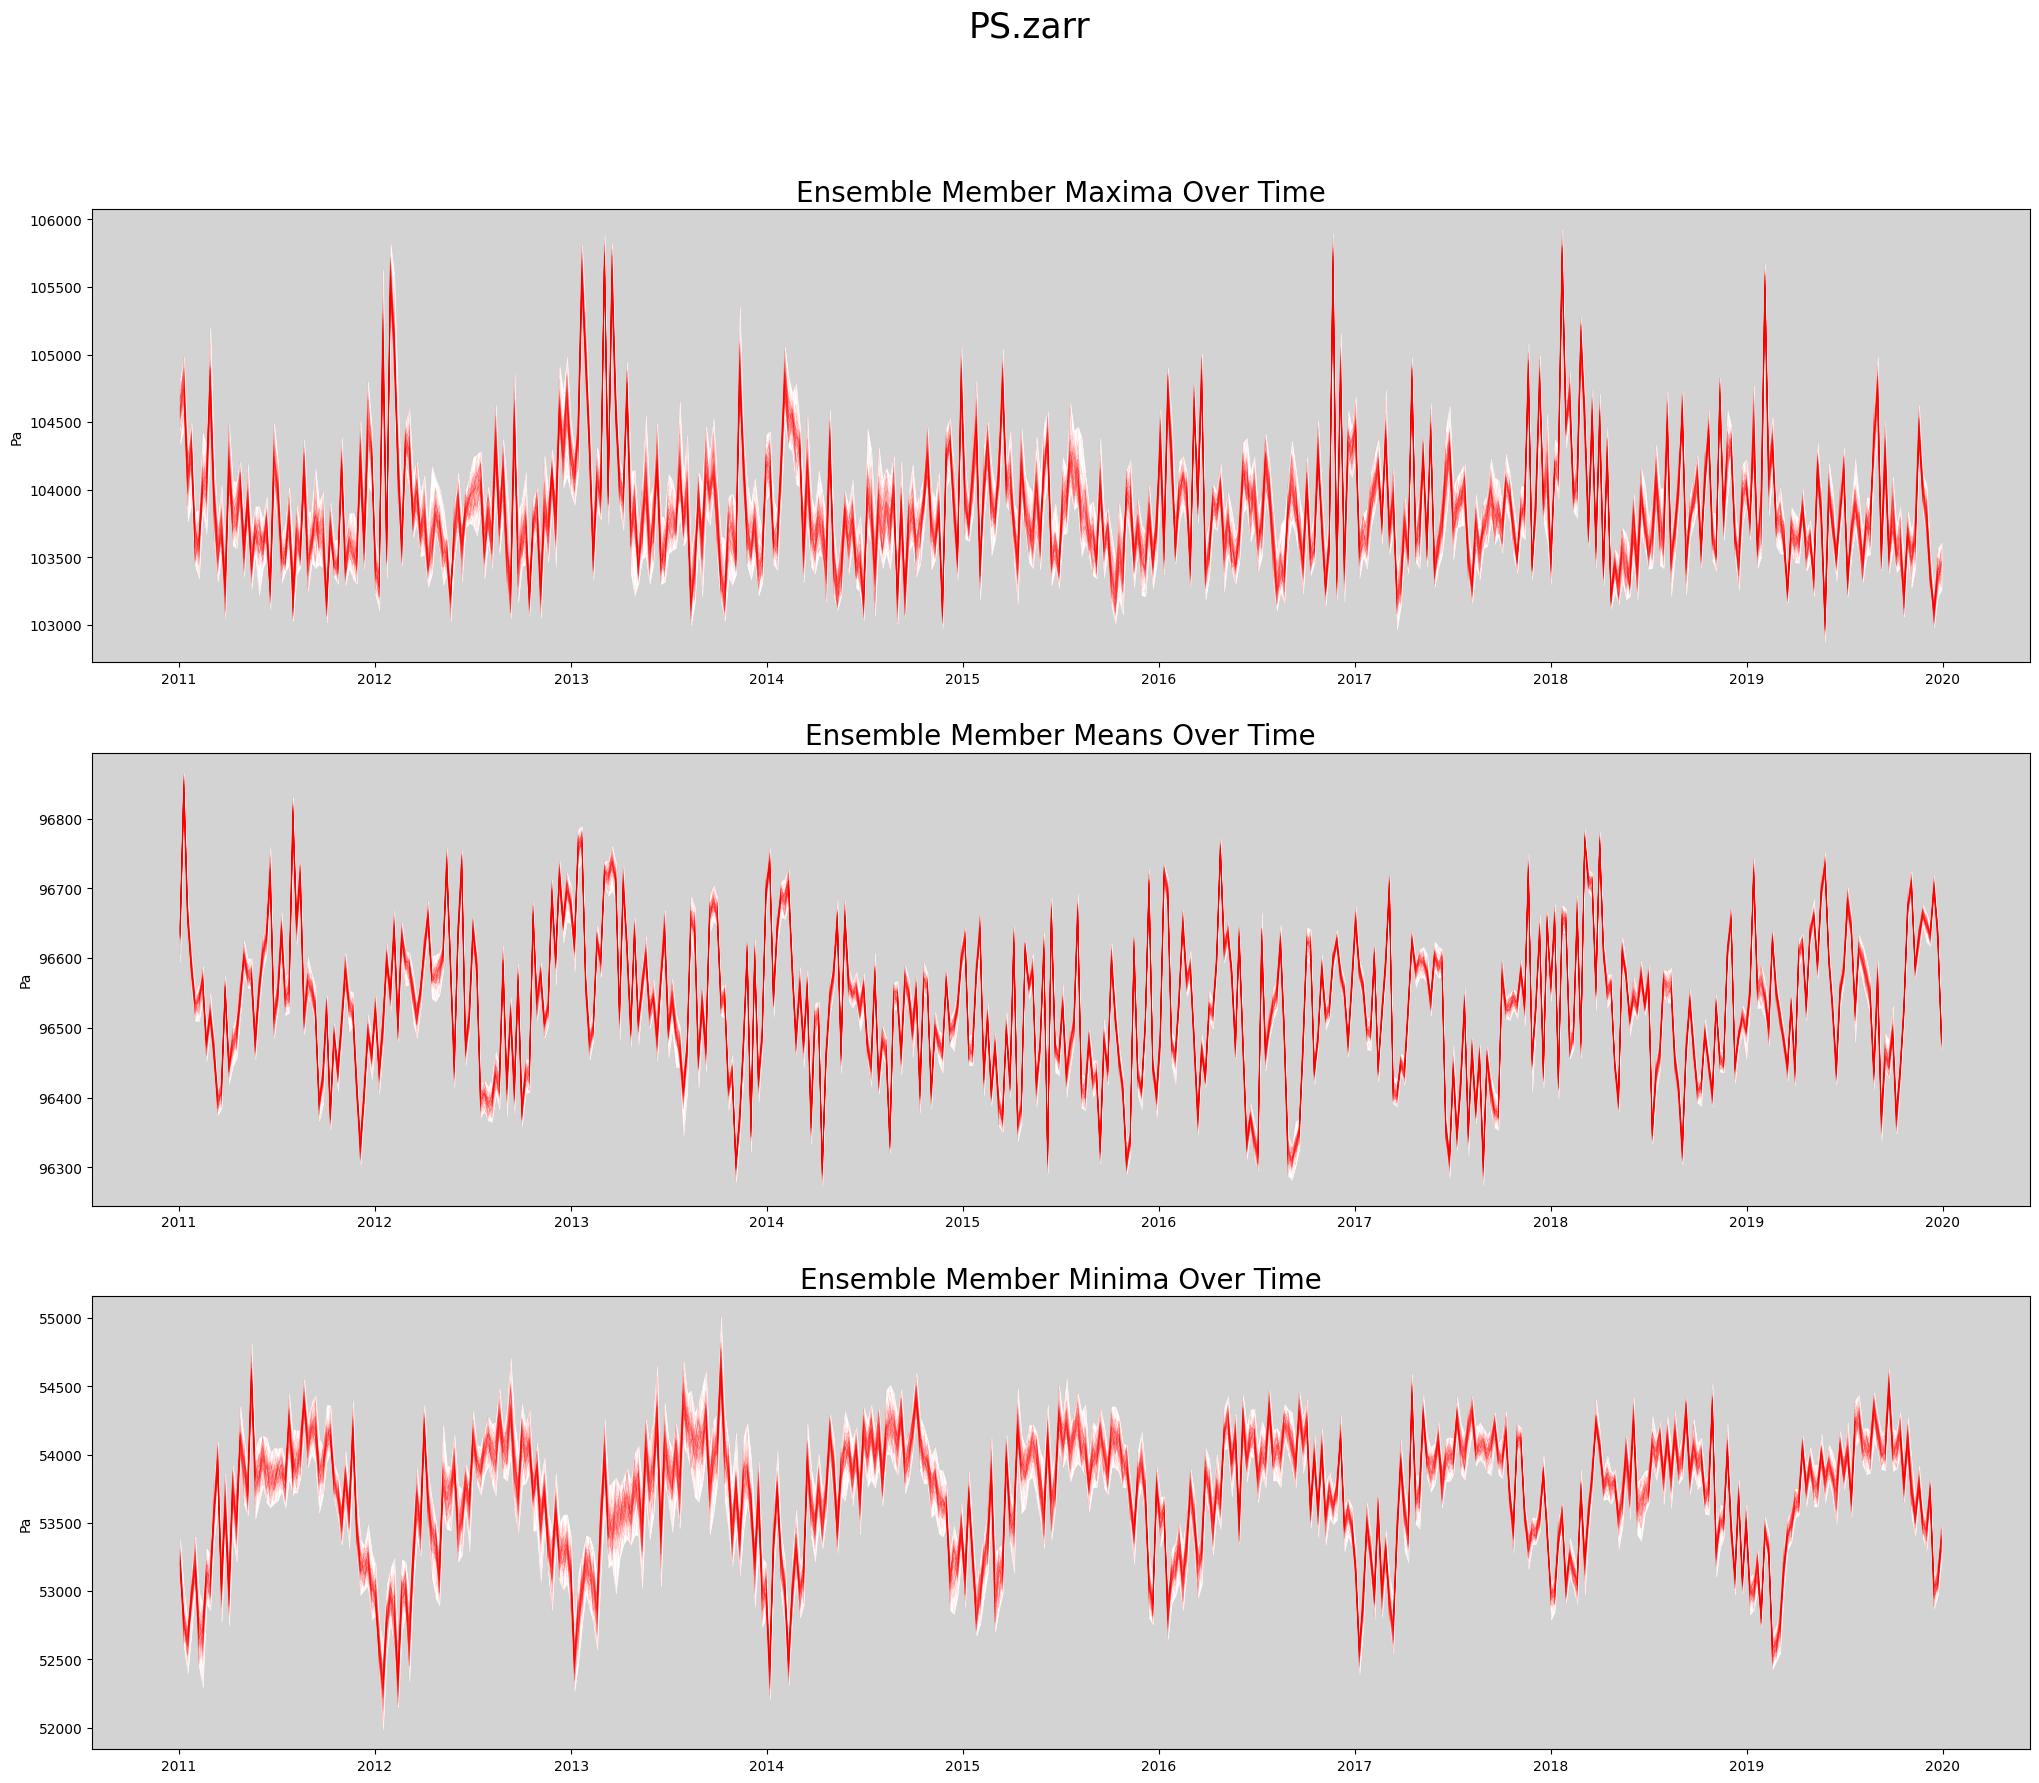

In [17]:
%%time

store_name = f'{data_var}.zarr'
fig = plot_timeseries(ds, data_var, store_name)


#### Release dask workers

In [18]:
cluster.close()